In [1]:
import argparse
from transformers import BertTokenizer
from collections import namedtuple
import random
import torch
import numpy as np
import re
import nltk
import spacy
import math
from neural_jacana.model import *
nlp = spacy.load('en_core_web_sm')

In [4]:
from utils_neural_jacana import *

In [2]:
def preprocess_texts(texts):
    tokenized_texts = []
    for text in texts:
        tokenized_texts.append(nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', text)))
    return tokenized_texts

def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

def check_inclusion(list1, list2):
    flag = False
    for i in list1:
        if i in list2:
            flag = True
    for i in list2:
        if i in list1:
            flag = True
    return flag

def merge_sent2_ids(align_id_pairs):
    '''
    merge sent2 ids aligned to sent1 ids.
    '''
    merged_sent2_align_id_pairs = []
    sorted_align_id_pairs = sorted(align_id_pairs, key=lambda x:(int(re.findall(r"\d+", x)[0]), int(re.findall(r"\d+", x)[1])))
    tuple_pairs = [(int(re.findall(r"\d+", i)[0]), int(re.findall(r"\d+", i)[1])) for i in sorted_align_id_pairs]
    for pair in tuple_pairs:
        keys = [i[0] for i in merged_sent2_align_id_pairs]
        keys_flatten = [x for row in keys for x in row]
        if pair[0] not in keys_flatten:
            merged_sent2_align_id_pairs.append(([pair[0]], [pair[1]]))
        else:
            ind_addval = [i for i in range(len(keys)) if pair[0] in keys[i]][0]
            merged_sent2_align_id_pairs[ind_addval][1].append(pair[1])
    return merged_sent2_align_id_pairs

def merge_sent1_ids(merged_sent2_align_id_pairs):
    '''
    merge sent1 ids having the same sent2 ids.
    '''
    merged_sent1_align_id_pairs = []
    dup_inds = []
    vals = [pair[1] for pair in merged_sent2_align_id_pairs]
    for pair in merged_sent2_align_id_pairs:
        dup_ind = [i for i, x in enumerate(vals) if x == pair[1]]
        if len(dup_ind) > 1:
            dup_inds.append(dup_ind)
    dup_inds = get_unique_list(dup_inds)

    if len(dup_inds) != 0: #if there are duplicate values in merged_sent2_align_id_pairs, they should be merged.
        keys_to_add = []
        for i in range(len(dup_inds)):
            key_to_add = []
            for j in range(len(merged_sent2_align_id_pairs)):
                if j in dup_inds[i]:
                    key_to_add.append(merged_sent2_align_id_pairs[j][0][0])
            if len(key_to_add) != 0:
                keys_to_add.append(key_to_add)
        
        pairs_to_add = []
        for i in range(len(dup_inds)):
            pairs_to_add.append((keys_to_add[i], merged_sent2_align_id_pairs[dup_inds[i][0]][1]))

        dup_inds_flatten = [x for row in dup_inds for x in row]
        for i in range(len(merged_sent2_align_id_pairs)):
            if i not in dup_inds_flatten:
                merged_sent1_align_id_pairs.append(merged_sent2_align_id_pairs[i])
        merged_sent1_align_id_pairs.extend(pairs_to_add)
        return merged_sent1_align_id_pairs
    
    else:
        return merged_sent2_align_id_pairs

def merge_align_ids_crossing(merged_ids):
    sent1_ids = [pair[0] for pair in merged_ids]
    sent2_ids = [pair[1] for pair in merged_ids]
    res = []
    added_sent1 = [0 for i in range(len(sent1_ids))]
    for i in range(len(sent1_ids)):
        sent2_ids_to_add = sent2_ids[i]
        sent1_correspond = sent1_ids[i]
        for j in range(i, len(sent1_ids)):
            if check_inclusion(sent1_ids[i], sent1_ids[j]) == True:
                if added_sent1[j] == 0 and i != j:
                    added_sent1[j] = 1
                    sent2_ids_to_add.extend(sent2_ids[j])
                    sent1_correspond.extend(sent1_ids[j])
                    sent1_correspond = get_unique_list(sent1_correspond)
        if len(sent2_ids_to_add) > 1 and added_sent1 == 0:
            res.append((sent1_correspond, sent2_ids_to_add))
            added_sent1[i] = 1
            #print(0)

    added_sent2 = [0 for i in range(len(sent2_ids))]
    for i in range(len(sent2_ids)):
        sent1_ids_to_add = sent1_ids[i]
        sent2_correspond = sent2_ids[i]
        for j in range(i, len(sent2_ids)):
            if check_inclusion(sent2_ids[i], sent2_ids[j]) == True:
                if added_sent2[j] == 0 and i != j:
                    added_sent2[j] = 1
                    sent1_ids_to_add.extend(sent1_ids[j])
                    sent2_correspond.extend(sent2_ids[j])
                    sent2_correspond = get_unique_list(sent2_correspond)
        if len(sent1_ids_to_add) > 1 and added_sent2[i] == 0:
            res.append((sent1_ids_to_add, sent2_correspond))
            added_sent2[i] = 1
            #print(1)

    for i in range(len(merged_ids)):
        if added_sent1[i] == 0 and added_sent2[i] == 0:
            res.append((sent1_ids[i], sent2_ids[i]))
            #print(2)
    #print(added_sent1, added_sent2)
    return res

def ids_to_words(merged_id_pairs, tokenized_sent1, tokenized_sent2):
    align_word_pairs = []
    for pair in merged_id_pairs:
        sent1_words = [tokenized_sent1[i] for i in pair[0]]
        sent2_words = [tokenized_sent2[i] for i in pair[1]]
        align_word_pairs.append((sent1_words, sent2_words))
    return align_word_pairs

In [211]:
a = ['0-0', '1-0', '2-0', '1-1', '2-2', '3-3']
a = ['0-0', '1-0', '1-1', '2-0', '2-2', '3-3', '3-4', '3-5', '4-4', '5-5', '6-6', '7-7']

In [212]:
merge_sent2_ids(a)

[([0], [0]),
 ([1], [0, 1]),
 ([2], [0, 2]),
 ([3], [3, 4, 5]),
 ([4], [4]),
 ([5], [5]),
 ([6], [6]),
 ([7], [7])]

In [215]:
merge_align_ids_crossing(merge_sent1_ids(merge_sent2_ids(a)))

[([0, 1, 2], [0, 1, 2]), ([3, 4, 5], [3, 4, 5]), ([6], [6]), ([7], [7])]

In [3]:
import pandas as pd
system_rating = pd.read_csv('./src/simplicity_DA.csv')
sources = []
targets = []
simp_zscores = []
for sid in range(1, 360):
    now = system_rating[system_rating['sent_id'] == sid]
    if len(now) != 0:
        sources.append(now['orig_sent'].iloc[0])
        targets.append(now['simp_sent'].iloc[0])
        simp_zscores.append(now['simplicity_zscore'])

/Users/yamanaka.h.ac/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [19]:
parser = argparse.ArgumentParser()
parser.add_argument("--batchsize", default=1, type=int)
parser.add_argument("--learning_rate", default=1e-5, type=float)
parser.add_argument("--max_epoch", default=6, type=int)
parser.add_argument("--max_span_size", default=4, type=int)
parser.add_argument("--max_seq_length", default=128, type=int)
parser.add_argument("--max_sent_length", default=70, type=int)
parser.add_argument("--seed", default=1234, type=int)
parser.add_argument("--dataset", default='mtref', type=str)
parser.add_argument("--sure_and_possible", default='True', type=str)
parser.add_argument("--distance_embedding_size", default=128, type=int)
parser.add_argument("--use_transition_layer", default='False', type=str, help='if False, will set transition score to 0.')
args = parser.parse_args(args=[])

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = NeuralWordAligner(args)
my_device = torch.device('cpu')
model = model.to(my_device)

checkpoint = torch.load('./neural_jacana/Checkpoint_sure_and_possible_True_dataset_mtref_batchsize_1_max_span_size_4_use_transition_layer_False_epoch_2_0.9150.pt', map_location=my_device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#sources = ["Military experts say the line between combat is getting blurry.", "Their eyes are quite small, and their visual acuity is poor.", 
#            "According to Ledford, Northrop executives said they would build substantial parts of the bomber in Palmdale, creating about 1,500 jobs.",
#            "In return, Rollo swore fealty to Charles, converted to Christianity, and undertook to defend the northern region of France against the Incursions of other Viking groups.",
#            "A fee is the price one pays as remuneration for services, especially the Honorarium paid to a doctor, lawyer, consultant, or other member of a learned profession.",
#            "Thereafter the county's administration was conducted at Duns or Lauder until Greenlaw became the county town in 1596.",
#            "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time.",
#            "As the largest sub-region in Mesoamerica, it encompassed a vast and varied landscape, from the mountainous regions of the Sierra Madre to the semi-arid plains of northern Yucatán.",
#            "Together they formed New Music Manchester, a group committed to contemporary music."]
#targets = ["Military experts say war is changing.", "Their eyes are very small, and they do not see well.",
#            "According to Ledford, Northrop said they would build most of the bomber parts in Palmdale. It would create 1,500 jobs.",
#            "Rollo swore to be loyal to Charles, then he changed his religion to Christianity. Rollo protected northern France by fighting Viking invaders.",
#            "A price one might pay for services is a called a fee.",
#            "After that, the county offices were at Duns or Lauder. In 1596 they moved to Greenlaw.",
#            "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb.",
#            "As the largest sub-region in Mesoamerica, it was a vast and varied landscape.",
#            "Both of the formed a group committed to contemporary music called new music Manchester."]
#sources = ["As the largest sub-region in Mesoamerica, it encompassed a vast and varied landscape, from the mountainous regions of the Sierra Madre to the semi-arid plains of northern Yucatán."]
#targets = ["As the largest sub-region in Mesoamerica, it was a vast and varied landscape."]
#sources = ['Together they formed New Music Manchester, a group committed to contemporary music.']
#targets = ['Both of the formed a group committed to contemporary music called new music Manchester.']
#sources = ['Characteristics Radar observations indicate a fairly pure iron-nickel composition.']
#targets = ['A mainly pure Iron-Nickel composition was observed by radar.']
#sources = ["MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."]
#targets = ["Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."]
sources = ['It continues as the Bohemian Switzerland in the Czech Republic.']
targets = ['It continues.']
nltk.download('punkt')
tokenized_sources = preprocess_texts(sources)
tokenized_targets = preprocess_texts(targets)

data = []
example = namedtuple('example', 'ID, text_a, text_b, label')
for i, (tokenized_source, tokenized_target) in enumerate(zip(tokenized_sources, tokenized_targets)):
    data.append(example(i, ' '.join(tokenized_source), ' '.join(tokenized_target), '0-0'))
test_dataloader = create_Data_Loader(data_examples=data, args=args, set_type='test', batchsize=1, max_seq_length=128, tokenizer=tokenizer)

for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(my_device) for t in batch)
    input_ids_a_and_b, input_ids_b_and_a, input_mask, segment_ids_a_and_b, segment_ids_b_and_a, sent1_valid_ids, sent2_valid_ids, sent1_wordpiece_length, sent2_wordpiece_length = batch
    with torch.no_grad():
        decoded_results = model(input_ids_a_and_b=input_ids_a_and_b, input_ids_b_and_a=input_ids_b_and_a,
                                    attention_mask=input_mask, token_type_ids_a_and_b=segment_ids_a_and_b,
                                    token_type_ids_b_and_a=segment_ids_b_and_a,
                                    sent1_valid_ids=sent1_valid_ids, sent2_valid_ids=sent2_valid_ids,
                                    sent1_wordpiece_length=sent1_wordpiece_length,
                                    sent2_wordpiece_length=sent2_wordpiece_length)
    align_id_pairs = list(decoded_results[0])
    #print(align_id_pairs)
    merged_sent2_align_id_pairs = merge_sent2_ids(align_id_pairs)
    merged_sent1_align_id_pairs = merge_sent1_ids(merged_sent2_align_id_pairs)
    merged_id_pairs = merge_align_ids_crossing(merged_sent1_align_id_pairs)
    align_word_pairs = ids_to_words(merged_id_pairs, tokenized_sources[step], tokenized_targets[step])
    #print(merged_id_pairs, align_word_pairs)

Some weights of BertModel were not initialized from the model checkpoint at neural_jacana/spanbert_hf_base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yamanaka.h.ac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processed test examples 0/1


KeyError: 6

In [ ]:
KeyError                                  Traceback (most recent call last)
<ipython-input-8-2b41582f4fa5> in <module>
     64     input_ids_a_and_b, input_ids_b_and_a, input_mask, segment_ids_a_and_b, segment_ids_b_and_a, sent1_valid_ids, sent2_valid_ids, sent1_wordpiece_length, sent2_wordpiece_length = batch
     65     with torch.no_grad():
---> 66         decoded_results = model(input_ids_a_and_b=input_ids_a_and_b, input_ids_b_and_a=input_ids_b_and_a,
     67                                     attention_mask=input_mask, token_type_ids_a_and_b=segment_ids_a_and_b,
     68                                     token_type_ids_b_and_a=segment_ids_b_and_a,

~/.pyenv/versions/3.8.5/lib/python3.8/site-packages/torch/nn/modules/module.py in _call_impl(self, *input, **kwargs)
    887             result = self._slow_forward(*input, **kwargs)
    888         else:
--> 889             result = self.forward(*input, **kwargs)
    890         for hook in itertools.chain(
    891                 _global_forward_hooks.values(),

~/Desktop/github_repos/simpeval/brute_force_edit_operation/neural_jacana/model.py in forward(self, input_ids_a_and_b, input_ids_b_and_a, attention_mask, token_type_ids_a_and_b, token_type_ids_b_and_a, sent1_valid_ids, sent2_valid_ids, sent1_wordpiece_length, sent2_wordpiece_length, labels_s2t, labels_t2s)
    491                 for d in range(batch_size):
    492                         extended_length_B = self.args.max_span_size*sent2_lengths[d]-int(self.args.max_span_size*(self.args.max_span_size-1)/2)
--> 493                         batch_dist_idx_list_B[d,:(extended_length_B+1),:(extended_length_B+1)] = self.transition_matrix_dict[extended_length_B]
    494                         tag_masks_sentB[d,:(extended_length_B+1),:(extended_length_B+1)]=np.ones((extended_length_B+1, extended_length_B+1))
    495 

KeyError: 6

In [13]:
print(step)
print(sources[step])
print(targets[step])

51
It continues as the Bohemian Switzerland in the Czech Republic.
It continues.


In [4]:
def edit_distance(sent1, sent2, max_id=4999):
    m = len(sent1)
    n = len(sent2)
    dp = [[0 for x in range(n+1)] for x in range(m+1)]
    for i in range(m+1):
        for j in range(n+1):
            if i == 0:
                dp[i][j] = j    # Min. operations = j
            elif j == 0:
                dp[i][j] = i    # Min. operations = i
            elif sent1[i-1].lower() == sent2[j-1].lower():
                dp[i][j] = dp[i-1][j-1]
            else:
                edit_candidates = np.array([
                    dp[i][j-1], # Insert
                    dp[i-1][j] # Remove
                    ])
                dp[i][j] = 1 + min(edit_candidates)
    return dp

def sent2edit(sent1, sent2):
    dp = edit_distance(sent1, sent2)
    edits = []
    pos = []
    m, n = len(sent1), len(sent2)
    while m != 0 or n != 0:
        curr = dp[m][n]
        if m==0: #have to insert all here
            while n>0:
                left = dp[1][n-1]
                edits.append(sent2[n-1])
                pos.append(left)
                n-=1
        elif n==0:
            while m>0:
                top = dp[m-1][n]
                edits.append('DEL')
                pos.append(top)
                m -=1
        else: # we didn't reach any special cases yet
            diag = dp[m-1][n-1]
            left = dp[m][n-1]
            top = dp[m-1][n]
            if sent2[n-1].lower() == sent1[m-1].lower(): # keep
                edits.append('KEEP')
                pos.append(diag)
                m -= 1
                n -= 1
            elif curr == top+1: # INSERT preferred before DEL
                edits.append('DEL')
                pos.append(top)  # (sent2[n-1])
                m -= 1
            else: #insert
                edits.append(sent2[n - 1])
                pos.append(left)  # (sent2[n-1])
                n -= 1
    edits = edits[::-1]
    return edits


def edit2sent(sent, edits, last=False):
    new_sent = []
    sent_pointer = 0 #counter the total of KEEP and DEL, then align with original sentence
    if len(edits) == 0 or len(sent) ==0: # edit_list empty, return original sent
        return sent
    for i, edit in enumerate(edits):
        if len(sent) > sent_pointer: #there are tokens left for editing
            if edit =="KEEP":
                new_sent.append(sent[sent_pointer])
                sent_pointer += 1
            elif edit =="DEL":
                sent_pointer += 1
            else: #insert the word in
                new_sent.append(edit)
    if sent_pointer < len(sent):
        for i in range(sent_pointer,len(sent)):
            new_sent.append(sent[i])
    return new_sent

In [10]:
#sent1 = "Military experts say the line between combat is getting blurry."
#sent2 = "Military experts say war is changing."
#sent1 = "According to Ledford, Northrop executives said they would build substantial parts of the bomber in Palmdale, creating about 1,500 jobs."
#sent2 = "According to Ledford, Northrop said they would build most of the bomber parts in Palmdale. It would create 1,500 jobs."
#sent1 = "Their eyes are quite small, and their visual acuity is poor."
#sent2 = "Their eyes are very small, and they do not see well."
sent1 = "In return, Rollo swore fealty to Charles, converted to Christianity, and undertook to defend the northern region of France against the Incursions of other Viking groups."
sent2 = "Rollo swore to be loyal to Charles, then he changed his religion to Christianity. Rollo protected northern France by fighting Viking invaders."
sent1 = "A fee is the price one pays as remuneration for services, especially the Honorarium paid to a doctor, lawyer, consultant, or other member of a learned profession."
sent2 = "A price one might pay for services is a called a fee."
sent1 = "Thereafter the county's administration was conducted at Duns or Lauder until Greenlaw became the county town in 1596."
sent2 = "After that, the county offices were at Duns or Lauder. In 1596 they moved to Greenlaw."
sent1 = "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."
sent2 = "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."
sent1 = "As the largest sub-region in Mesoamerica, it encompassed a vast and varied landscape, from the mountainous regions of the Sierra Madre to the semi-arid plains of northern Yucatán."
sent2 = "As the largest sub-region in Mesoamerica, it was a vast and varied landscape."
sent1 = 'The tongue is sticky because of the presence of glycoprotein-rich mucous, which both lubricates movement in and out of the snout and helps to catch ants and termites, which adhere to it.'
sent2 = 'The sticky tongue helps to catch bugs.'
sent1 = 'The polymer is most often epoxy, but other polymers, such as polyester, vinyl Ester or nylon, are also sometimes used.'
sent2 = 'The most popular polymer to use is epoxy.'
sent1 = 'Together they formed New Music Manchester, a group committed to contemporary music.'
sent2 = 'Both of the formed a group committed to contemporary music called new music Manchester.'
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))

A = edit_distance(sent1_tok, sent2_tok, max_id=4999)

In [32]:
sent1 = "The International fight League was an American mixed martial arts( Mma) promotion billed as the world's first Mma League."
sent2 = "The International fight League was billed as the world's first mixed martial arts (Mma) League."

In [23]:
sent1 = "Aside from this, Cameron has often worked in Christian-Themed productions, among them the Post-Rapture films left behind: the movie, left behind II: tribulation force, and left behind: world at war, in which he plays Cameron `` Buck'' Williams."
sent2 = 'Cameron has often worked in Christian-Themed productions, among them are left behind: the movie, left behind II: tribulation force, and left behind: world at war, in which he plays Cameron "Buck" Williams.'

In [5]:
sent1 = 'Characteristics Radar observations indicate a fairly pure iron-nickel composition.'
sent2 = 'A mainly pure Iron-Nickel composition was observed by radar.'

In [33]:
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))

In [36]:
B = sent2edit(sent1_tok, sent2_tok)
print(B)
print(edit2sent(sent1_tok,B))

['KEEP', 'KEEP', 'by', 'KEEP', 'KEEP', 'KEEP', 'KEEP', 'KEEP', 'stop', 'DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'from', 'working', '.', 'later', 'DEL', 'DEL', 'KEEP', 'KEEP', 'DEL', 'KEEP', 'KEEP', 'an', 'event', 'from', 'DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'KEEP', '.', 'as', 'a', 'result', ',', 'he', 'runs', 'DEL', 'DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'KEEP', 'to', 'stop', 'the', 'bomb', 'KEEP']
['MacGruber', 'starts', 'by', 'asking', 'for', 'simple', 'objects', 'to', 'stop', 'the', 'bomb', 'from', 'working', '.', 'later', 'he', 'is', 'distracted', 'by', 'an', 'event', 'from', 'his', 'personal', 'life', '.', 'as', 'a', 'result', ',', 'he', 'runs', 'out', 'of', 'time', 'to', 'stop', 'the', 'bomb', '.']


In [5]:
def extract_ad_spans(edits):
    ad_spans = []
    seen_a = [0 for i in range(len(edits))]
    for i in range(len(edits) - 1):
        if seen_a[i] != 1:
            if edits[i] != 'KEEP' and edits[i] != 'DEL':
                start = i
                j = i + 1
                flag = False
                while j < len(edits):
                    if edits[j] == 'DEL':
                        j += 1
                        flag = True
                    elif edits[j] != 'KEEP' and edits[j] != 'DEL':
                        if flag == False:
                            seen_a[j] = 1
                            j += 1
                        else:
                            break
                    else:
                        break
                if flag == True:
                    end = j - 1
                    if end - start > 0:
                        ad_spans.append((start, end))
    return ad_spans

In [6]:
def extract_d_starts_from_ad_spans(edits, ad_spans):
    d_starts = []
    for span in ad_spans:
        a_start = span[0]
        d_start = a_start
        while d_start < len(edits):
            if edits[d_start] != 'DEL':
                d_start += 1
            else:
                break
        d_starts.append(d_start)
    return d_starts

In [37]:
extract_ad_spans(B)

[(8, 12), (15, 20), (26, 32), (36, 47)]

In [38]:
extract_d_starts_from_ad_spans(B, extract_ad_spans(B))

[9, 19, 29, 43]

In [17]:
sent1 = "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."
sent2 = "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
aligns = [([21, 22], [21]), ([0], [0]), ([1], [1, 2]), ([2], [3]), ([3], [4]), ([4], [5]), ([5], [6]), ([6], [7]), ([10], [8]), ([11], [37]), ([12], [38]), ([13], [13]), ([15], [15]), ([16], [16]), ([17], [14]), ([18], [17]), ([19], [18]), ([20], [19, 20]), ([23], [22]), ([24], [23]), ([25], [24]), ([28], [30]), ([29], [31]), ([30], [32]), ([31], [33]), ([32], [34]), ([33], [39])] 

In [12]:
print(sent1_tok)
print(sent2_tok)

['MacGruber', 'starts', 'asking', 'for', 'simple', 'objects', 'to', 'make', 'something', 'to', 'defuse', 'the', 'bomb', ',', 'but', 'he', 'is', 'later', 'distracted', 'by', 'something', 'usually', 'involving', 'his', 'personal', 'life', 'that', 'makes', 'him', 'run', 'out', 'of', 'time', '.']
['Macgruber', 'starts', 'by', 'asking', 'for', 'simple', 'objects', 'to', 'stop', 'the', 'bomb', 'from', 'working', '.', 'later', 'he', 'is', 'distracted', 'by', 'an', 'event', 'from', 'his', 'personal', 'life', '.', 'as', 'a', 'result', ',', 'he', 'runs', 'out', 'of', 'time', 'to', 'stop', 'the', 'bomb', '.']


In [18]:
ad_spans = extract_ad_spans(edits)

In [7]:
def assign_ids_to_edits(edits, sent2_tok):
    edits_ids = []
    sent1_pointer = 0
    sent2_pointer = 0
    for i in range(len(edits)):
        if edits[i] == 'KEEP':
            edits_ids.append(sent1_pointer)
            sent1_pointer += 1
        elif edits[i] == 'DEL':
            edits_ids.append(sent1_pointer)
            sent1_pointer += 1
        else:
            while sent2_pointer < len(sent2_tok):
                if sent2_tok[sent2_pointer] == edits[i]:
                    edits_ids.append(sent2_pointer)
                    sent2_pointer += 1
                    break
                else:
                    sent2_pointer += 1
    return edits_ids

In [20]:
print(edits)
print(assign_ids_to_edits(edits, sent2_tok))

['KEEP', 'KEEP', 'by', 'KEEP', 'KEEP', 'KEEP', 'KEEP', 'KEEP', 'stop', 'DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'from', 'working', '.', 'later', 'DEL', 'DEL', 'KEEP', 'KEEP', 'DEL', 'KEEP', 'KEEP', 'an', 'event', 'from', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'KEEP', '.', 'as', 'a', 'result', ',', 'he', 'runs', 'DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'KEEP', 'KEEP', 'to', 'stop', 'the', 'bomb', 'KEEP']
[0, 1, 2, 2, 3, 4, 5, 6, 8, 7, 8, 9, 10, 11, 12, 11, 12, 13, 14, 13, 14, 15, 16, 17, 18, 19, 19, 20, 21, 20, 21, 22, 23, 24, 25, 25, 26, 27, 28, 29, 30, 31, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 33]


In [67]:
sent1 = "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."
sent2 = "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
aligns = [([21, 22], [21]), ([0], [0]), ([1], [1, 2]), ([2], [3]), ([3], [4]), ([4], [5]), ([5], [6]), ([6], [7]), ([10], [8]), ([11], [37]), ([12], [38]), ([13], [13]), ([15], [15]), ([16], [16]), ([17], [14]), ([18], [17]), ([19], [18]), ([20], [19, 20]), ([23], [22]), ([24], [23]), ([25], [24]), ([28], [30]), ([29], [31]), ([30], [32]), ([31], [33]), ([32], [34]), ([33], [39])] 

In [83]:
print(len(edits))
print(len(assign_ids_to_edits(edits, sent2_tok)))

54
54


In [17]:
ad_spans

[(8, 12), (15, 20), (26, 31), (35, 45)]

In [8]:
def extract_splr_ids(edits, ad_spans, sent2_tok):
    edits_ids = assign_ids_to_edits(edits, sent2_tok)
    splr_ids = []
    for ad_span_idx in range(len(ad_spans)):
        splr_flag = False
        for i in range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1] + 1):
            if edits[i] == '.':
                splr_flag = True
        if splr_flag == True:
            #sent1_span = [edits_ids[j] for j in range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1) if edits[j] == 'KEEP' or edits[j] == 'DEL']
            #sent2_span = [edits_ids[j] for j in range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1) if edits[j] != 'KEEP' and edits[j] != 'DEL']
            #splr_ids.append((sent1_span, sent2_span, ad_span_idx))
            splr_ids.append(['splr_span', ad_span_idx])
    return splr_ids

In [69]:
splr_ids = extract_splr_ids(edits, ad_spans, sent2_tok)
print(splr_ids)

[['splr_span', 1], ['splr_span', 3]]


In [70]:
ad_spans_done = [i[1] for i in splr_ids]
print(ad_spans_done)

[1, 3]


In [87]:
ad_spans

[(8, 12), (15, 20), (26, 31), (35, 45)]

In [88]:
d_starts = extract_d_starts_from_ad_spans(edits, ad_spans)
print(d_starts)

[9, 19, 29, 42]


In [91]:
sent1_tok[9:13]

['to', 'defuse', 'the', 'bomb']

In [93]:
edits[8:13]

['stop', 'DEL', 'DEL', 'DEL', 'DEL']

In [19]:
sent1 = "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."
sent2 = "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
aligns = [([21, 22], [21]), ([0], [0]), ([1], [1, 2]), ([2], [3]), ([3], [4]), ([4], [5]), ([5], [6]), ([6], [7]), ([10], [8]), ([11], [37]), ([12], [38]), ([13], [13]), ([15], [15]), ([16], [16]), ([17], [14]), ([18], [17]), ([19], [18]), ([20], [19, 20]), ([23], [22]), ([24], [23]), ([25], [24]), ([28], [30]), ([29], [31]), ([30], [32]), ([31], [33]), ([32], [34]), ([33], [39])] 

In [9]:
def extract_rep_ids(edits, ad_spans, sent2_tok, aligns, splr_ids):
    edits_ids = assign_ids_to_edits(edits, sent2_tok)
    d_starts = extract_d_starts_from_ad_spans(edits, ad_spans)
    rep_ids = []
    ad_spans_done = [i[1] for i in splr_ids]
    for ad_span_idx in range(len(ad_spans)):
        if ad_span_idx in ad_spans_done:
            continue
        else:
            now_span = ad_spans[ad_span_idx]
            d_start_in_now_span = d_starts[ad_span_idx]
            d_span_in_now_span = list(range(d_start_in_now_span, now_span[1]+1))
            a_span_in_now_span = list(range(now_span[0], d_start_in_now_span))
            sent1_ids_corresponding_d_span_in_now_span = [edits_ids[i] for i in d_span_in_now_span if edits[i] == 'DEL']
            sent2_ids_corresponding_a_span_in_now_span = [edits_ids[i] for i in a_span_in_now_span if edits[i] != 'DEL']

            added_words_to_sent1_by_a_span = []
            for i in range(len(sent2_ids_corresponding_a_span_in_now_span)):
                added_words_to_sent1_by_a_span.append(sent2_tok[sent2_ids_corresponding_a_span_in_now_span[i]])

            aligned_words_in_sent2 = []
            for i in range(len(sent1_ids_corresponding_d_span_in_now_span)):
                for j in range(len(aligns)):
                    if sent1_ids_corresponding_d_span_in_now_span[i] in aligns[j][0]:
                        for aligned_word_id in aligns[j][1]:
                            aligned_words_in_sent2.append(sent2_tok[aligned_word_id])

            rep_flag = False
            for word in aligned_words_in_sent2:
                if word in added_words_to_sent1_by_a_span:
                    rep_flag = True
            
            if rep_flag == True:
                rep_ids.append(['rep_span', ad_span_idx])
    
    return rep_ids

In [73]:
rep_ids = extract_rep_ids(edits, ad_spans, sent2_tok, aligns, ad_spans_done)
print(rep_ids)

[['rep_span', 0], ['rep_span', 2]]


In [108]:
print(sent1_tok[7:11], sent2_tok[8:9])

['make', 'something', 'to', 'defuse'] ['stop']


In [109]:
print(sent1_tok[20:23], sent2_tok[19:22])

['something', 'usually', 'involving'] ['an', 'event', 'from']


In [26]:
test_d_span = [9, 10, 11, 12]
test_d_span = [29, 30, 31]
edits_ids = assign_ids_to_edits(edits, sent2_tok)
sent1_span = [edits_ids[i] for i in test_d_span if edits[i] == 'DEL']
aligned_words_in_sent2 = []
for i in range(len(sent1_span)):
    for j in range(len(aligns)):
        if sent1_span[i] in aligns[j][0]:
            for aligned_word_id in aligns[j][1]:
                aligned_words_in_sent2.append(sent2_tok[aligned_word_id])
print(aligned_words_in_sent2)

['an', 'event', 'from', 'from']


In [32]:
sent1 = 'Characteristics Radar observations indicate a fairly pure iron-nickel composition.'
sent2 = 'A mainly pure Iron-Nickel composition was observed by radar.'
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
aligns = [([1, 2], [8]), ([3], [6, 7]), ([4], [0]), ([5], [1]), ([6], [2]), ([7], [3]), ([8], [4]), ([9], [9])]

In [33]:
print(edits)
print(ad_spans)

['DEL', 'DEL', 'DEL', 'DEL', 'KEEP', 'mainly', 'DEL', 'KEEP', 'KEEP', 'KEEP', 'was', 'observed', 'by', 'radar', 'KEEP']
[(5, 6)]


In [10]:
def extract_d_spans(edits):
    d_spans = []
    flag = False
    seen = [0 for i in range(len(edits))]
    for i in range(len(edits)):
        if seen[i] != 1:
            seen[i] = 1
            if edits[i] != 'KEEP' and edits[i] != 'DEL':
                flag = True
            elif edits[i] == 'KEEP':
                flag = False
            else:
                if flag == True:
                    continue
                else:
                    start = i
                    j = i + 1
                    while j < len(edits):
                        if edits[j] == 'DEL':
                            seen[j] = 1
                            j += 1
                        elif edits[j] == 'KEEP':
                            break
                        else:
                            flag = True
                            break
                    end = j - 1
                    if end - start >= 0:
                        d_spans.append((start, end))
    return d_spans        

In [34]:
extract_d_spans(edits)

[(0, 3)]

In [11]:
def extract_a_spans(edits):
    a_spans = []
    seen_a = [0 for i in range(len(edits))]
    for i in range(len(edits)):
        if seen_a[i] != 1:
            seen_a[i] = 1
            if edits[i] != 'KEEP' and edits[i] != 'DEL':
                start = i
                j = i + 1
                while j < len(edits):
                    flag = False
                    if edits[j] != 'KEEP' and edits[j] != 'DEL':
                        seen_a[j] = 1
                        j += 1
                    elif edits[j] == 'DEL':
                        flag = True
                        break
                    else:
                        break
                end = j - 1
                if (flag == False) and (end - start >= 0):
                    a_spans.append((start, end))
    return a_spans

In [44]:
extract_a_spans(edits)

[(10, 13)]

In [12]:
def extract_mvr_ids(edits, ad_spans, d_spans, a_spans, sent2_tok, aligns):
    edits_ids = assign_ids_to_edits(edits, sent2_tok)
    mvr_ids = []
    seen_a_span = [0 for i in range(len(a_spans))]
    seen_ad_span = [0 for i in range(len(ad_spans))]
    for d_span_idx in range(len(d_spans)):
        tmp_ids = ['mvr_span']
        d_span = list(range(d_spans[d_span_idx][0], d_spans[d_span_idx][1]+1))
        sent1_ids_corresponding_d_span = [edits_ids[i] for i in d_span if edits[i] == 'DEL']

        aligned_words_in_sent2_from_d_span = []
        for i in range(len(sent1_ids_corresponding_d_span)):
            for j in range(len(aligns)):
                if sent1_ids_corresponding_d_span[i] in aligns[j][0]:
                    for aligned_word_id in aligns[j][1]:
                        aligned_words_in_sent2_from_d_span.append(sent2_tok[aligned_word_id])
        
        if len(aligned_words_in_sent2_from_d_span) == 0:
            continue
        else:
            tmp_ids.append(('d_span', d_span_idx))

            # check a_spans
            for a_span_idx in range(len(a_spans)):
                a_span = list(range(a_spans[a_span_idx][0], a_spans[a_span_idx][1]+1))
                if d_span[-1] > a_span[0]:
                    continue
                else:
                    sent2_ids_corresponding_a_span = [edits_ids[i] for i in a_span if edits[i] != 'DEL']
                    added_words_to_sent1_by_a_span = []
                    for i in range(len(sent2_ids_corresponding_a_span)):
                        added_words_to_sent1_by_a_span.append(sent2_tok[sent2_ids_corresponding_a_span[i]])
                    
                    flag = False
                    for word in aligned_words_in_sent2_from_d_span:
                        if word in added_words_to_sent1_by_a_span:
                            flag = True
                    if flag == True:
                        if seen_a_span[a_span_idx] == 0:
                            tmp_ids.append(('a_span', a_span_idx))
                            seen_a_span[a_span_idx] = 1
            
            # check ad_span
            d_starts = extract_d_starts_from_ad_spans(edits, ad_spans)
            for ad_span_idx in range(len(ad_spans)):
                ad_span = list(range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1))
                if d_span[-1] > ad_span[0]:
                    continue
                else:
                    d_start_in_ad_span = d_starts[ad_span_idx]
                    d_span_in_ad_span = list(range(d_start_in_ad_span, ad_span[-1]+1))
                    a_span_in_ad_span = list(range(ad_span[0], d_start_in_ad_span))
                    sent1_ids_corresponding_d_span_in_ad_span = [edits_ids[i] for i in d_span_in_ad_span if edits[i] == 'DEL']
                    sent2_ids_corresponding_a_span_in_ad_span = [edits_ids[i] for i in a_span_in_ad_span if edits[i] != 'DEL']
                    
                    added_words_to_sent1_by_a_span_in_ad_span = []
                    for i in range(len(sent2_ids_corresponding_a_span_in_ad_span)):
                        added_words_to_sent1_by_a_span_in_ad_span.append(sent2_tok[sent2_ids_corresponding_a_span_in_ad_span[i]])

                    aligned_words_in_sent2_from_ad_span = []
                    for i in range(len(sent1_ids_corresponding_d_span_in_ad_span)):
                        for j in range(len(aligns)):
                            if sent1_ids_corresponding_d_span_in_ad_span[i] in aligns[j][0]:
                                for aligned_word_id in aligns[j][1]:
                                    aligned_words_in_sent2_from_ad_span.append(sent2_tok[aligned_word_id])
                    
                    flag = False
                    if len(aligned_words_in_sent2_from_ad_span) == 0:
                        flag = True
                    for word in aligned_words_in_sent2_from_d_span:
                        if word in added_words_to_sent1_by_a_span_in_ad_span:
                            flag = True
                    if flag == True:
                        if seen_ad_span[ad_span_idx] == 0:
                            tmp_ids.append(('ad_span', ad_span_idx))
                            seen_ad_span[ad_span_idx] = 1

            mvr_ids.append(tmp_ids)
    return mvr_ids

In [13]:
def extract_d_ids(edits, d_spans, sent2_tok, aligns):
    edits_ids = assign_ids_to_edits(edits, sent2_tok)
    d_ids = []
    for d_span_idx in range(len(d_spans)):
        d_span = list(range(d_spans[d_span_idx][0], d_spans[d_span_idx][1]+1))
        sent1_ids_corresponding_d_span = [edits_ids[i] for i in d_span if edits[i] == 'DEL']

        aligned_words_in_sent2_form_d_span = []
        for i in range(len(sent1_ids_corresponding_d_span)):
            for j in range(len(aligns)):
                if sent1_ids_corresponding_d_span[i] in aligns[j][0]:
                    for aligned_word_id in aligns[j][1]:
                        aligned_words_in_sent2_form_d_span.append(sent2_tok[aligned_word_id])
        
        if len(aligned_words_in_sent2_form_d_span) == 0:
            d_ids.append(['d_span', d_span_idx])
    
    return d_ids

In [14]:
def extract_a_ids(a_spans, mvr_ids):
    a_ids = []
    a_spans_done = []
    for mvr_info in mvr_ids:
        for i in range(1, len(mvr_info)):
            if mvr_info[i][0] == 'a_span':
                a_spans_done.append(mvr_info[i][1])

    for a_span_idx in range(len(a_spans)):
        if a_span_idx in a_spans_done:
            continue
        else:
            a_ids.append(['a_span', a_span_idx])

    return a_ids

A [fee is the] price one pays as remuneration for services [(is) , especially the Honorarium paid to] a [(called) doctor, lawyer, consultant, or other member of] a [(fee) Kearney profession] .  
  
  
A [] price one pays as remuneration for services [(is) ] a [(called) ] a [(fee) ] .  
  

move-rephrase spanは、alignmentありd_spanと、それより後ろにある、「条件」を満たしたa_span/ad_spanをまとめたもの。  
条件（a_span）：今見ているd_spanのalignment先の単語を含んでいる
条件（ad_span）：今見ているd_spanのalignment先の単語を含んでいる、またはad_span中のd_spanが1つもalignmentを持たない

In [81]:
sent1 = 'Characteristics Radar observations indicate a fairly pure iron-nickel composition.'
sent2 = 'A mainly pure Iron-Nickel composition was observed by radar.'
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
d_spans = extract_d_spans(edits)
a_spans = extract_a_spans(edits)
aligns = [([1, 2], [8]), ([3], [6, 7]), ([4], [0]), ([5], [1]), ([6], [2]), ([7], [3]), ([8], [4]), ([9], [9])]

In [28]:
sent1 = "MacGruber starts asking for simple objects to make something to defuse the bomb, but he is later distracted by something (usually involving his personal life) that makes him run out of time."
sent2 = "Macgruber starts by asking for simple objects to stop the bomb from working. later he is distracted by an event from his personal life. as a result, he runs out of time to stop the bomb."
sent1_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent1))
sent2_tok = nltk.word_tokenize(re.sub(r'[\(\)\`\'\"]', '', sent2))
edits = sent2edit(sent1_tok, sent2_tok)
ad_spans = extract_ad_spans(edits)
d_spans = extract_d_spans(edits)
a_spans = extract_a_spans(edits)
aligns = [([21, 22], [21]), ([0], [0]), ([1], [1, 2]), ([2], [3]), ([3], [4]), ([4], [5]), ([5], [6]), ([6], [7]), ([10], [8]), ([11], [37]), ([12], [38]), ([13], [13]), ([15], [15]), ([16], [16]), ([17], [14]), ([18], [17]), ([19], [18]), ([20], [19, 20]), ([23], [22]), ([24], [23]), ([25], [24]), ([28], [30]), ([29], [31]), ([30], [32]), ([31], [33]), ([32], [34]), ([33], [39])] 

In [121]:
print(ad_spans)

[(8, 12), (15, 20), (26, 31), (35, 45)]


In [59]:
def create_text_to_edit(edits, sent1_tok, sent2_tok):
    text_to_edit = []
    edits_ids = assign_ids_to_edits(edits, sent2_tok)

    doc_sent1 = nlp(" ".join(sent1_tok))
    sent1_tok_pos_lemma = []
    for i, token in enumerate(doc_sent1):
        sent1_tok_pos_lemma.append([sent1_tok[i], token.pos_, token.lemma_])

    doc_sent2 = nlp(" ".join(sent2_tok))
    sent2_tok_pos_lemma = []
    for i, token in enumerate(doc_sent2):
        sent2_tok_pos_lemma.append([sent2_tok[i], token.pos_, token.lemma_])
 
    for i in range(len(edits)):
        if edits[i] == 'DEL' or edits[i] == 'KEEP':
            text_to_edit.append([sent1_tok_pos_lemma[edits_ids[i]][0], sent1_tok_pos_lemma[edits_ids[i]][1], sent1_tok_pos_lemma[edits_ids[i]][2]])
        else:
            word_in_sent2 = sent2_tok_pos_lemma[edits_ids[i]][0]
            word_in_sent2 = 'ADD_' + word_in_sent2
            text_to_edit.append([word_in_sent2, sent2_tok_pos_lemma[edits_ids[i]][1], sent2_tok_pos_lemma[edits_ids[i]][2]])
    return text_to_edit

In [73]:
text_to_edit = create_text_to_edit(edits, sent1_tok, sent2_tok)
print(text_to_edit)

[['MacGruber', 'PROPN', 'MacGruber'], ['starts', 'VERB', 'start'], ['ADD_by', 'ADP', 'by'], ['asking', 'VERB', 'ask'], ['for', 'ADP', 'for'], ['simple', 'ADJ', 'simple'], ['objects', 'NOUN', 'object'], ['to', 'PART', 'to'], ['ADD_stop', 'VERB', 'stop'], ['make', 'VERB', 'make'], ['something', 'PRON', 'something'], ['to', 'PART', 'to'], ['defuse', 'VERB', 'defuse'], ['the', 'DET', 'the'], ['bomb', 'NOUN', 'bomb'], ['ADD_from', 'ADP', 'from'], ['ADD_working', 'VERB', 'work'], ['ADD_.', 'PUNCT', '.'], ['ADD_later', 'ADV', 'later'], [',', 'PUNCT', ','], ['but', 'CCONJ', 'but'], ['he', 'PRON', 'he'], ['is', 'AUX', 'be'], ['later', 'ADV', 'later'], ['distracted', 'VERB', 'distract'], ['by', 'ADP', 'by'], ['ADD_an', 'DET', 'an'], ['ADD_event', 'NOUN', 'event'], ['ADD_from', 'ADP', 'from'], ['something', 'PRON', 'something'], ['usually', 'ADV', 'usually'], ['involving', 'VERB', 'involve'], ['his', 'PRON', 'his'], ['personal', 'ADJ', 'personal'], ['life', 'NOUN', 'life'], ['ADD_.', 'PUNCT', '.'

In [36]:
print(text_to_edit[2][0][4:])

by


In [151]:
def tree_height(root):
    if not list(root.children):
        return 1
    else:
        return 1 + max(tree_height(x) for x in root.children)

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [152]:
def calc_max_deptree_depth(str_text):
    doc = nlp(str_text)
    roots = [sent.root for sent in doc.sents]
    return max([tree_height(root) for root in roots])

In [15]:
import pandas as pd
freq_data = pd.read_csv('./src/lemmas_60k_m2166.txt', skiprows=8, header=0, delimiter='\t')

In [29]:
math.log(freq_data[(freq_data['PoS'] == 'j') | (freq_data['PoS'] == 'r') | (freq_data['PoS'] == 'n') | (freq_data['PoS'] == 'v')]['freq'].iloc[0])

17.29350711581128

In [30]:
freq_data

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
0,1,the,a,50033612,50385.16,0.11,0.00,482995,0.98,6266654,...,6579270,7440931,50434.35,55169.32,29524.14,45672.67,53310.74,53941.86,54042.73,62116.23
1,2,be,v,32394756,32622.71,0.03,0.01,481177,0.99,5594001,...,4102481,3689062,45020.81,41409.63,62695.87,55701.50,37289.40,33259.44,33698.16,30795.96
2,3,and,c,24778098,24952.20,0.09,0.00,478670,0.98,3205178,...,2993061,3627686,25795.44,26849.01,14249.23,26275.16,25860.15,26177.63,24585.28,30283.60
3,4,a,a,24225478,24395.69,0.04,0.04,478204,0.99,3098338,...,3299770,2602697,24935.58,24747.22,20690.47,23374.72,25107.33,27541.93,27104.62,21727.08
4,5,of,i,23159162,23321.89,0.01,0.00,477933,0.97,2897295,...,2867922,4500485,23317.58,26588.36,10918.77,20157.43,19270.82,25796.39,23557.38,37569.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60995,60996,hand-embroidered,j,42,0.04,0.00,0.00,41,0.76,1,...,9,0,0.01,0.02,0.03,0.00,0.12,0.10,0.07,0.00
60996,60997,wast,n,42,0.04,0.02,0.00,32,0.63,11,...,2,3,0.09,0.11,0.07,0.00,0.02,0.01,0.02,0.03
60997,60998,watchband,n,42,0.04,0.02,0.02,38,0.73,4,...,6,0,0.03,0.02,0.02,0.02,0.15,0.05,0.05,0.00
60998,60999,weak-side,j,42,0.04,0.07,0.00,39,0.70,7,...,27,0,0.06,0.02,0.01,0.00,0.02,0.02,0.22,0.00


In [57]:
freq_data[freq_data['lemma'] == 'folly']

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
9858,9859,folly,n,3795,3.82,0.21,0.01,2893,0.95,543,...,504,518,4.37,5.94,1.62,1.6,4.18,4.45,4.14,4.32


In [58]:
freq_data[freq_data['lemma'] == 'foolishness']

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
14914,14915,foolishness,n,1781,1.79,0.03,0.01,1534,0.93,311,...,105,98,2.5,2.71,1.39,0.5,4.57,1.09,0.86,0.82


In [70]:
freq_data[(freq_data['lemma'] == 'always') & (freq_data['PoS'] == 'r')]

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
190,191,always,r,492943,496.41,0.04,0.01,182046,0.99,74076,...,44261,27114,596.17,504.87,646.53,505.19,683.52,437.45,363.56,226.35


In [48]:
data = freq_data['perMil'].tolist()

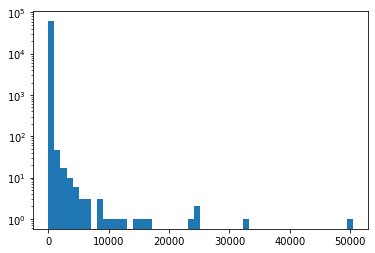

In [54]:
import matplotlib.pyplot as plt
plt.hist(data, bins=50)
plt.yscale('log')

In [74]:
def calc_lexical_comp(text_tok_pos_lemma):
    score = 0
    for i in range(len(text_tok_pos_lemma)):
        pos = text_tok_pos_lemma[i][1]
        if pos == 'ADJ':
            lemma = text_tok_pos_lemma[i][2]
            score += math.log(freq_data[(freq_data['lemma'] == lemma) & (freq_data['PoS'] == 'j')]['perMil'])
        if pos == 'ADV':
            lemma = text_tok_pos_lemma[i][2]
            score += math.log(freq_data[(freq_data['lemma'] == lemma) & (freq_data['PoS'] == 'r')]['perMil'])
        if pos == 'NOUN':
            lemma = text_tok_pos_lemma[i][2]
            score += math.log(freq_data[(freq_data['lemma'] == lemma) & (freq_data['PoS'] == 'n')]['perMil'])
        if pos == 'VERB':
            lemma = text_tok_pos_lemma[i][2]
            score += math.log(freq_data[(freq_data['lemma'] == lemma) & (freq_data['PoS'] == 'v')]['perMil'])
    return score

In [76]:
added_words = [['ADD_stop', 'VERB', 'stop']]
deleted_words = [['make', 'VERB', 'make'], ['something', 'PRON', 'something'], ['to', 'PART', 'to'], ['defuse', 'VERB', 'defuse']]
print(calc_lexical_comp(added_words))
print(calc_lexical_comp(deleted_words))

5.911175975879146
8.342509416366052


In [78]:
def calc_del_score(words):
    return len(words)

In [79]:
def append_influence_scores_to_edit_sequence(edits, ad_spans, d_spans, a_spans, edit_sequence, text_to_edit, sent1_tok):
    influence_scores = []
    for edit_span_id in edit_sequence:

        if edit_span_id[0] == 'splr_span' or edit_span_id[0] == 'mvr_span':
            edited_text_tok = []
            ad_span_idx = edit_span_id[1]
            ad_span = list(range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1))
            for i in range(len(text_to_edit)):
                if i in ad_span:
                    if edits[i] == 'DEL':
                        continue
                    else:
                        edited_text_tok.append(text_to_edit[i][0][4:])
                else:
                    if edits[i] == 'DEL' or edits[i] == 'KEEP':
                        edited_text_tok.append(text_to_edit[i][0])
                    else:
                        continue
            syn_score = calc_max_deptree_depth(" ".join(sent1_tok)) - calc_max_deptree_depth(" ".join(edited_text_tok))
            if edit_span_id[0] == 'splr_span':
                influence_scores.append(['splr_span', edit_span_id[1], syn_score])
            elif edit_span_id[0] == 'mvr_span':
                influence_scores.append(['mvr_span', edit_span_id[1], syn_score])
        
        if edit_span_id[0] == 'rep_span':
            added_words = []
            deleted_words = []
            ad_span_idx = edit_span_id[1]
            ad_span = list(range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1))
            for i in range(len(text_to_edit)):
                if i in ad_span:
                    if edits[i] == 'DEL':
                        deleted_words.append(text_to_edit[i])
                    else:
                        added_words.append(text_to_edit[i])            
            rep_score = calc_lexical_comp(deleted_words) - calc_lexical_comp(added_words)
            influence_scores.append(['rep_span', edit_span_id[1], rep_score])
        
        if edit_span_id[0] == 'd_span':
            deleted_words = []
            d_span_idx = edit_span_id[1]
            d_span = list(range(d_spans[d_span_idx][0], d_spans[d_span_idx][1]+1))
            for i in range(len(text_to_edit)):
                if i in d_span:
                    deleted_words.append(text_to_edit[i])         
            del_score = calc_del_score(deleted_words)
            influence_scores.append(['d_span', edit_span_id[1], del_score])
        
        if edit_span_id[0] == 'a_span':
            influence_scores.append(['a_span', edit_span_id[1], 0])

    return influence_scores

In [ ]:
def apply_edit_to_text(edits, ad_spans, d_spans, a_spans, splr_ids, rep_ids, mvr_ids, d_ids, a_ids, text_to_edit, sent1_tok):
    edit_sequence = splr_ids + rep_ids + mvr_ids + d_ids + a_ids
    edit_sequence = append_influence_scores_to_edit_sequence(edits, ad_spans, d_spans, a_spans, edit_sequence, text_to_edit, sent1_tok)
    edited_texts = []
    for bit in range(1<<len(edit_sequence)):
        apply_edit_sequence = []
        for i in range(len(edit_sequence)):
            mask = 1 << i
            if bit&mask:
                apply_edit_sequence += [edit_sequence[i]]
        #print(apply_edit_sequence)

        edited_text = []    
        seen_text_to_edit = [0 for i in range(len(text_to_edit))]
        influence_score = 0
        for apply_edit in apply_edit_sequence:
            if apply_edit[0] == 'splr_span':
                influence_score += apply_edit[2]
                edited_text_for_calc_score = []
                ad_span_idx = apply_edit[1]
                ad_span = list(range(ad_spans[ad_span_idx][0], ad_spans[ad_span_idx][1]+1))
                for i in range(len(text_to_edit)):
                    if i in ad_span:
                        if edits[i] == 'DEL':
                            continue
                        else:


In [95]:
splr_ids = extract_splr_ids(edits, ad_spans, sent2_tok)
rep_ids = extract_rep_ids(edits, ad_spans, sent2_tok, aligns, splr_ids)

mvr_ids = extract_mvr_ids(edits, ad_spans, d_spans, a_spans, sent2_tok, aligns)
d_ids = extract_d_ids(edits, d_spans, sent2_tok, aligns)
a_ids = extract_a_ids(a_spans, mvr_ids)

In [120]:
edit_sequence = splr_ids + rep_ids + mvr_ids + d_ids + a_ids
print(edit_sequence)
for bit in range(1<<len(edit_sequence)):
    if bit == 0 or bit == (1<<len(edit_sequence))-1:
        continue
    else:
        apply_edit_sequence = []
        for i in range(len(edit_sequence)):
            mask = 1 << i
            if bit&mask:
                apply_edit_sequence += [edit_sequence[i]]
        print(apply_edit_sequence)

[['splr_span', 1], ['splr_span', 3], ['rep_span', 0], ['rep_span', 2], ['mvr_span', ('d_span', 0)], ['a_span', 0], ['a_span', 1]]
[['splr_span', 1]]
[['splr_span', 3]]
[['splr_span', 1], ['splr_span', 3]]
[['rep_span', 0]]
[['splr_span', 1], ['rep_span', 0]]
[['splr_span', 3], ['rep_span', 0]]
[['splr_span', 1], ['splr_span', 3], ['rep_span', 0]]
[['rep_span', 2]]
[['splr_span', 1], ['rep_span', 2]]
[['splr_span', 3], ['rep_span', 2]]
[['splr_span', 1], ['splr_span', 3], ['rep_span', 2]]
[['rep_span', 0], ['rep_span', 2]]
[['splr_span', 1], ['rep_span', 0], ['rep_span', 2]]
[['splr_span', 3], ['rep_span', 0], ['rep_span', 2]]
[['splr_span', 1], ['splr_span', 3], ['rep_span', 0], ['rep_span', 2]]
[['mvr_span', ('d_span', 0)]]
[['splr_span', 1], ['mvr_span', ('d_span', 0)]]
[['splr_span', 3], ['mvr_span', ('d_span', 0)]]
[['splr_span', 1], ['splr_span', 3], ['mvr_span', ('d_span', 0)]]
[['rep_span', 0], ['mvr_span', ('d_span', 0)]]
[['splr_span', 1], ['rep_span', 0], ['mvr_span', ('d_spa

In [97]:
print(splr_ids)
print(rep_ids)
print(mvr_ids)
print(d_ids)
print(a_ids)

[['splr_span', 1], ['splr_span', 3]]
[['rep_span', 0], ['rep_span', 2]]
[['mvr_span', ('d_span', 0)]]
[]
[['a_span', 0], ['a_span', 1]]


In [ ]:
def insert_rep_span(edits, ad_spans, aligns, sent1_tok, sent2_tok, slp_spans):
    d_starts = extract_d_starts(edits, ad_spans)
    aligns_sent1_ids = [i[0] for i in aligns]
    aligns_sent2_ids = [i[1] for i in aligns]
    for span, d_start in zip(ad_spans, d_starts):
        d_seen = [0 for i in range(len(d_start))]
        a_wordlist = [sent2_tok[i] for i in range(span[0], d_start)]
        edit_to_inserts = []
        #d_pointer = d_start
        for d_pointer in range(d_start, span[1]):
            for i in range(len(aligns_sent1_ids)):
                if d_pointer in aligns_sent1_ids[i] and d_seen[d_pointer - d_start] != 0:
                    d_seen[d_pointer - d_start] = 1
                    sent2_ids = aligns_sent2_ids[i]
                    sent2_words = [sent2_tok[i] for i in sent2_ids]
                    edit_to_insert = ['REP-S']
                    for sent2_word in sent2_words:
                        if sent2_word in a_wordlist:
                            edit_to_insert.append(sent2_word)
                    edit_to_insert.append('REP-E')
                    if len(edit_to_insert) > 2:
                        edit_to_inserts.append(edit_to_insert)


        for i in range(len(aligns_sent1_ids)):
            if d_pointer in aligns_sent1_ids[i] and d_seen[d_pointer - d_start] != 0:
                d_seen[d_pointer - d_start] = 1
                sent2_ids = aligns_sent2_ids[i]
                sent2_words = [sent2_tok[i] for i in sent2_ids]
                edit_to_insert = ['REP-S']
                for sent2_word in sent2_words:
                    if sent2_word in a_wordlist:
                        edit_to_insert.append(sent2_word)
                edit_to_insert.append('REP-E')
                if len(edit_to_insert) > 2:
                    edit_to_inserts.append(edit_to_insert)
            d_pointer += 1
            